![人工智慧 - 自由團隊](https://raw.githubusercontent.com/chenkenanalytic/img/master/af/aifreeteam.png)


<center>Welcome to the data deployment practice of Traditional Chinese Handwriting Dataset by AI . FREE Team.</center>
<br>
<center>歡迎大家來到 AI . FREE Team 所開發的繁體中文手寫資料部署實作。 </center>
<br>

<center>(Author: Chen Ken, Yen-Lin 博士；Date of published: 2020/4/21；AI . FREE Team Website: https://aifreeblog.herokuapp.com/)</center>

In [15]:
!git clone https://github.com/AI-FREE-Team/Traditional-Chinese-Handwriting-Dataset.git --depth 1

Cloning into 'Traditional-Chinese-Handwriting-Dataset'...
remote: Enumerating objects: 15, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 15 (delta 0), reused 12 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (15/15), 76.70 MiB | 15.59 MiB/s, done.


In [18]:
from platform import python_version
import os
import shutil
import numpy as np
import pandas as pd
import PIL.Image
from matplotlib import pyplot as plt
from matplotlib.font_manager import findfont, FontProperties
from pathlib import Path
import zipfile
import shutil
import threading
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout  
from tensorflow.keras.optimizers import *

'''
繁體中文顯示設定
'''
from matplotlib.font_manager import FontProperties

default_type = findfont( FontProperties( family=FontProperties().get_family() ) )
ttf_path = Path('/'.join( default_type.split('/')[:-1] ))  # 預設字型的資料夾路徑 


DisplayChinese = Path("./matplotlib_Display_Chinese_in_Colab")
if not DisplayChinese.exists(  ):
    !git clone https://github.com/YenLinWu/matplotlib_Display_Chinese_in_Colab --depth 1

msj_name = ""
for item in DisplayChinese.glob( '*.ttf' ):  
    msj_ttf_path = item.absolute()
    msj_name = msj_ttf_path.name


try:  
    shutil.move( msj_ttf_path, ttf_path )
except: 
    pass
finally:
    shutil.rmtree( DisplayChinese )
font = FontProperties( fname=ttf_path/msj_name )

CurrentFolder = Path(".")
OutputFolder = Path('./Handwritten_Data')
TmpFolder = Path('./tmp_extract')

In [ ]:


if TmpFolder.exists():
  shutil.rmtree(TmpFolder)
Path(OutputFolder).mkdir(exist_ok=True)
Path(TmpFolder).mkdir(exist_ok=True)

CompressedFiles = []

for item in Path(CurrentFolder / "Traditional-Chinese-Handwriting-Dataset" / "data").iterdir(): # Iterate through items in OutputFolder.
  if item.suffix == '.zip': # Check for ".zip" extension.
    CompressedFiles.append(item.absolute())

def unzip(zip_path: Path):
    print(f'Start to decompress {zip_path} ......')
    # Construct a ZipFile object with the filename, and then extract it.
    ZipTmpFolder = TmpFolder / zip_path.name
    zipfile.ZipFile(zip_path).extractall(ZipTmpFolder)

    source_path = Path(ZipTmpFolder / "cleaned_data(50_50)")
    img_list = source_path.iterdir()

    for img in img_list:
        if OutputFolder.joinpath(img.name).exists():
            continue

        shutil.move(img, OutputFolder) # Move a file to another location.


    shutil.rmtree(source_path)
    print(f'Decompress successfully {zip_path} ......')

unzip_joinset = [threading.Thread(target=unzip, args=(link,)) for link in CompressedFiles]

for thread in unzip_joinset:
    thread.start()

for thread in unzip_joinset:
    thread.join()

print( 'Moving images according to traditional Chinese characters......' )

ImageList = list(OutputFolder.glob('*.png'))
ImageList = [img for img in ImageList if len(img.name)>1]
WordList = list(set([w.name.split('_')[0] for w in ImageList]))

def CreateMoveImageThread(w: str):
    (OutputFolder / w).mkdir(exist_ok=True) # Create the new word folder in OutputPath.
    MoveList = [img for img in ImageList if w in img.name]

    [shutil.move(img, OutputFolder / w / img.name) for img in MoveList]


MoveJoinSet: list[threading.Thread] = [threading.Thread(target=CreateMoveImageThread, args=(w,)) for w in WordList]

for thread in MoveJoinSet:
    thread.start()

for thread in tqdm(MoveJoinSet, desc="Moving images"):
    thread.join()

shutil.rmtree(TmpFolder)
print( 'Data Deployment completed.' )

Start to decompress /tmp/a/Traditional-Chinese-Handwriting-Dataset/data/cleaned_data(50_50)-20200420T071507Z-004.zip ......
Start to decompress /tmp/a/Traditional-Chinese-Handwriting-Dataset/data/cleaned_data(50_50)-20200420T071507Z-003.zip ......
Start to decompress /tmp/a/Traditional-Chinese-Handwriting-Dataset/data/cleaned_data(50_50)-20200420T071507Z-002.zip ......
Start to decompress /tmp/a/Traditional-Chinese-Handwriting-Dataset/data/cleaned_data(50_50)-20200420T071507Z-001.zip ......
Decompress successfully /tmp/a/Traditional-Chinese-Handwriting-Dataset/data/cleaned_data(50_50)-20200420T071507Z-004.zip ......
Decompress successfully /tmp/a/Traditional-Chinese-Handwriting-Dataset/data/cleaned_data(50_50)-20200420T071507Z-001.zip ......
Decompress successfully /tmp/a/Traditional-Chinese-Handwriting-Dataset/data/cleaned_data(50_50)-20200420T071507Z-003.zip ......
Decompress successfully /tmp/a/Traditional-Chinese-Handwriting-Dataset/data/cleaned_data(50_50)-20200420T071507Z-002.zip

Moving images: 100%|██████████| 4803/4803 [00:00<00:00, 76670.18it/s]

Data Deployment completed.


In [5]:
a=0
b=0

for item in OutputFolder.iterdir():
  a += 1
  b += len(list(item.iterdir()))

print('總共: ' + str(a) + '個字, ' + str(b) + '張圖片')

總共: 4803個字, 250712張圖片


In [33]:
from pathlib import Path
import random
import cv2
import numpy as np
import shutil

SrcFolder = Path('./Handwritten_Data')
DstFolder = Path('./Processed_Handwritten_Data')

if DstFolder.exists():
    shutil.rmtree(DstFolder)

DstFolder.mkdir(parents=True)


def apply_random_transform(image: cv2.Mat) -> cv2.Mat:
    """
    Apply random transformations to an image: rotation, shearing, scaling
    """
    rows, cols = image.shape[:2]

    # Random rotation (-180 to 180 degrees)
    angle = random.uniform(-180, 180)
    rotation_matrix = cv2.getRotationMatrix2D((cols/2, rows/2), angle, 1)

    # Random scaling (0.75 to 1.25)
    scale = random.uniform(0.75, 1.25)
    scaled_matrix = rotation_matrix.copy()
    scaled_matrix[0, 0] *= scale
    scaled_matrix[1, 1] *= scale

    # Random shearing
    shear_x = random.uniform(-0.3, 0.3)
    shear_y = random.uniform(-0.3, 0.3)
    shear_matrix = np.float32([[1, shear_x, 0], [shear_y, 1, 0]])

    # Apply transformations
    rotated = cv2.warpAffine(image, scaled_matrix, (cols, rows), borderValue=(255, 255, 255))
    transformed = cv2.warpAffine(rotated, shear_matrix, (cols, rows), borderValue=(255, 255, 255))

    return transformed

def process_and_save_images(n=10):
    """
    Process images in the source folder, apply transformations, and save to destination folder
    """
    CharFolders = [f for f in SrcFolder.iterdir() if f.is_dir()][:n]
    for CharFolder in CharFolders:
        DstCharFolder = DstFolder / CharFolder.name
        DstCharFolder.mkdir(parents=True, exist_ok=True)
        ImgFiles = list(CharFolder.glob('*.png'))
        for ImgFile in ImgFiles:
            image = cv2.imread(str(ImgFile), cv2.IMREAD_GRAYSCALE)
            cv2.imwrite(str(DstCharFolder / f"{ImgFile.stem}_0.png"), image)  # Save original image
            transformed_images = [apply_random_transform(image) for _ in range(5)]
            for i, transformed_image in enumerate(transformed_images):
                DstImgFile = DstCharFolder / f"{ImgFile.stem}_{i + 1}.png"
                cv2.imwrite(str(DstImgFile), transformed_image)


process_and_save_images(4)

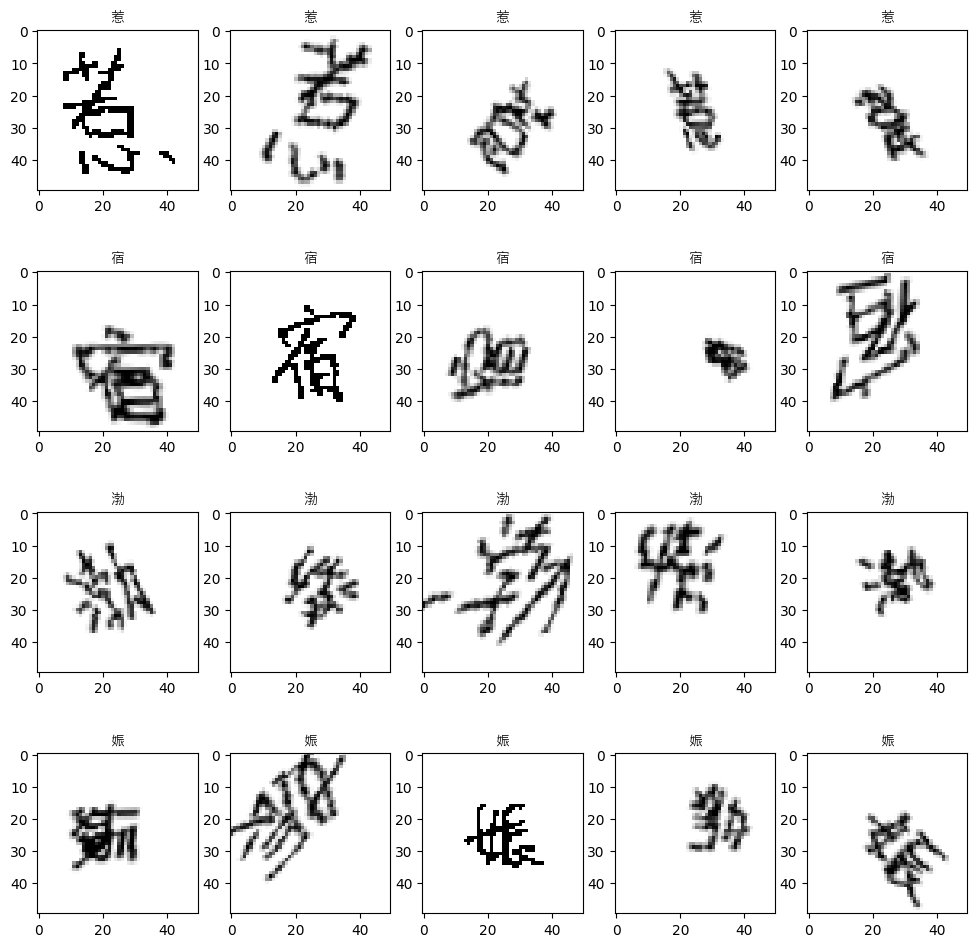

In [34]:
def Loading_Image( image_path ):
    img = load_img( image_path )  
    img = tf.constant( np.array(img) )  
    return img

def Show( image, title=None ) :
    if len( image.shape )>3 :
        image = tf.squeeze( image, axis=0 )   

    plt.imshow( image )
    if title:
        plt.title( title, fontproperties=font )

img_list: list[Path] = []
for folder_path in DstFolder.iterdir():
    file_names = os.listdir( folder_path )
    for i in range(5) :
        img_list.append( folder_path / file_names[i] )

plt.gcf().set_size_inches( (12,12) ) 
for i in range(20):      
    plt.subplot(4,5,i+1)
    title = img_list[i].name.split('_')[-3]
    img = Loading_Image( img_list[i] )
    Show( img, title )

In [35]:
Num_Classes = len(list( DstFolder.iterdir()))
Image_Size = ( 50, 50 )
Epochs = 50
Batch_Size = 8

In [36]:
Train_Data_Genetor = ImageDataGenerator( rescale = 1./255, validation_split = 0.2,
                                         width_shift_range = 0.05,   
                                         height_shift_range = 0.05,
                                         zoom_range = 0.1,  
                                         horizontal_flip = False )

In [37]:
Train_Generator = Train_Data_Genetor.flow_from_directory( DstFolder ,
                                                          target_size = Image_Size,
                                                          batch_size = Batch_Size,
                                                          class_mode = 'categorical',
                                                          shuffle = True, 
                                                          subset = 'training' )

Found 975 images belonging to 4 classes.


batch 1: 
 shape of images: (8, 50, 50, 3) 
 shape of labels: (8, 4)
batch 2: 
 shape of images: (8, 50, 50, 3) 
 shape of labels: (8, 4)
batch 3: 
 shape of images: (8, 50, 50, 3) 
 shape of labels: (8, 4)
batch 4: 
 shape of images: (8, 50, 50, 3) 
 shape of labels: (8, 4)
batch 5: 
 shape of images: (8, 50, 50, 3) 
 shape of labels: (8, 4)
batch 6: 
 shape of images: (8, 50, 50, 3) 
 shape of labels: (8, 4)
batch 7: 
 shape of images: (8, 50, 50, 3) 
 shape of labels: (8, 4)
batch 8: 
 shape of images: (8, 50, 50, 3) 
 shape of labels: (8, 4)
batch 9: 
 shape of images: (8, 50, 50, 3) 
 shape of labels: (8, 4)
batch 10: 
 shape of images: (8, 50, 50, 3) 
 shape of labels: (8, 4)
batch 11: 
 shape of images: (8, 50, 50, 3) 
 shape of labels: (8, 4)
batch 12: 
 shape of images: (8, 50, 50, 3) 
 shape of labels: (8, 4)
batch 13: 
 shape of images: (8, 50, 50, 3) 
 shape of labels: (8, 4)
batch 14: 
 shape of images: (8, 50, 50, 3) 
 shape of labels: (8, 4)
batch 15: 
 shape of images: 

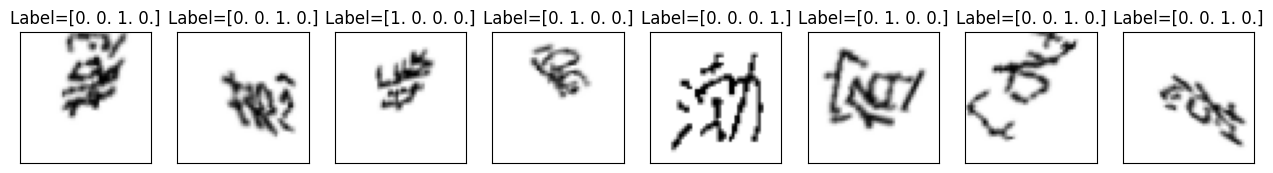

In [38]:
def Plot_Genetor( imgs, labels=[], grid=(1,10), size=(20,2) ):
    n = len( imgs )             
    plt.gcf().set_size_inches(size) 
    for i in range(n):           
        ax = plt.subplot( grid[0], grid[1], i+1 )   
        ax.imshow( imgs[i] )            
        if len(labels):
            ax.set_title( f'Label={labels[i]}' )   
        ax.set_xticks([]); ax.set_yticks([]) 
    # plt.show()  

batch = 1
for data, label in Train_Generator:
    print( f'batch {batch}: \n shape of images: {data.shape} \n shape of labels: {label.shape}' )
    Plot_Genetor( data, label )
    batch += 1
    if batch > len(Train_Generator): 
        break

print( f'There are {len(Train_Generator)} batches.' )

In [39]:
Val_Data_Genetor = ImageDataGenerator( rescale=1./255, validation_split = 0.2 )

In [40]:
Val_Generator = Train_Data_Genetor.flow_from_directory( DstFolder ,
                                                        target_size = Image_Size,
                                                        batch_size = Batch_Size,
                                                        class_mode = 'categorical',
                                                        shuffle = True, 
                                                        subset = 'validation' )

Found 243 images belonging to 4 classes.


In [41]:
CNN = Sequential( name = 'CNN_Model' )
CNN.add( Conv2D( 5, kernel_size = (2,2), padding = 'same', 
                 input_shape = (Image_Size[0],Image_Size[1],3), name = 'Convolution' ) )
CNN.add( MaxPooling2D( pool_size = (2,2), name = 'Pooling' ) )
CNN.add( Flatten( name = 'Flatten' ) )
CNN.add( Dropout( 0.5, name = 'Dropout_1' ) )
CNN.add( Dense( 512, activation = 'relu', name = 'Dense' ) )
CNN.add( Dropout( 0.5, name = 'Dropout_2' ) )
CNN.add( Dense( Num_Classes, activation = 'softmax', name = 'Softmax' ) )
CNN.summary()

Model: "CNN_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Convolution (Conv2D)            │ (None, 50, 50, 5)      │            65 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Pooling (MaxPooling2D)          │ (None, 25, 25, 5)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten (Flatten)               │ (None, 3125)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_1 (Dropout)             │ (None, 3125)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense (Dense)                   │ (None, 512)            │     1,600,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Softmax (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,602,629 (6.11 MB)

 Trainable params: 1,602,629 (6.11 MB)

 Non-trainable params: 0 (0.00 B)

In [42]:
CNN.compile( optimizer = Adam(),
             loss = 'categorical_crossentropy', 
             metrics = ['accuracy'] )

In [43]:
History = CNN.fit( Train_Generator,
                   steps_per_epoch = Train_Generator.samples//Batch_Size,
                   validation_data = Val_Generator,
                   validation_steps = Val_Generator.samples//Batch_Size,
                   epochs = Epochs )

Epoch 1/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.2544 - loss: 1.6183 - val_accuracy: 0.2583 - val_loss: 1.4049
Epoch 2/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1250 - loss: 1.5502 - val_accuracy: 0.2667 - val_loss: 1.3955
Epoch 3/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.2761 - loss: 1.3884 - val_accuracy: 0.2458 - val_loss: 1.3677
Epoch 4/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2500 - loss: 1.4880 - val_accuracy: 0.2708 - val_loss: 1.3636
Epoch 5/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.3071 - loss: 1.3817 - val_accuracy: 0.3083 - val_loss: 1.3639
Epoch 6/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 1.6246 - val_accuracy: 0.3375 - val_loss: 1.3609
Epoch 7/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.3206 - loss: 1.3574 - val_accuracy: 0.3375 - val_loss: 1.3271
Epoch 8/50
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3750 - loss: 1.2860 - val_accu

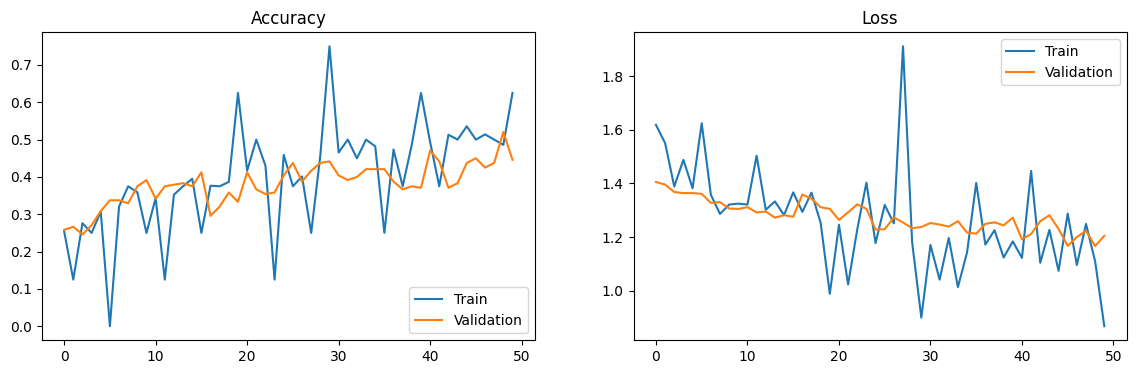

In [44]:
Train_Accuracy = History.history['accuracy']
Val_Accuracy = History.history['val_accuracy']
Train_Loss = History.history['loss']
Val_Loss = History.history['val_loss']
epochs_range = range(Epochs)

plt.figure( figsize=(14,4) )
plt.subplot( 1,2,1 )
plt.plot( range( len(Train_Accuracy) ), Train_Accuracy, label='Train' ) 
plt.plot( range( len(Val_Accuracy) ), Val_Accuracy, label='Validation' ) 
plt.legend( loc='lower right' )
plt.title( 'Accuracy' )

plt.subplot( 1,2,2 )
plt.plot( range( len(Train_Loss) ), Train_Loss, label='Train' )
plt.plot( range( len(Val_Loss) ), Val_Loss, label='Validation' )
plt.legend( loc='upper right' )
plt.title( 'Loss')

plt.show()